### Ambient Temperature Analysis in an office setting ###

<br> *Date: Feb 2021*


Anomaly Detection — is the identification of rare items, events, or patterns that significantly differ from the majority of the data.

##  Table of Contents 
#### 1. [Data](#data)
#### 2. [Exploratory Data Analysis](#eda)
#### 3. [Feature Engineering](#fe)
#### 4.[ Model Development](#md)
4.1 [Statistical Model](#sm)
4.2 [Clustering](#CL)
4.3 [Classification](#cla)
#### 5. [Conclusions](#con)

In [64]:
# Load packages 
import pandas as pd
import numpy as np
from datetime import datetime, date

import seaborn as sns 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import plotly as py
import plotly.graph_objs as go

from fbprophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import statsmodels.api as sm

plt.style.use("fivethirtyeight")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a id = "data"></a>
#### 1. Data

* Load data from github: specify timestamp data type 

In [65]:
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv'
df = pd.read_csv(url, error_bad_lines=False, parse_dates=['timestamp'])

In [66]:
# Check data
# Temperature was recorded every hour 
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7267 non-null   datetime64[ns]
 1   value      7267 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 113.7 KB


In [68]:
# Keep a copy of original dataframe
df_origin = df.copy(deep=True)

<a id = "eda"></a>
#### 2. Exploratory Data Analysis

#### Question 1 Explore ####
* Shape of data: 7267 rows, 2 columns
* Characteristic of data: time series data. It records temperature from 2013-07 to 2014-05. Every record was stored by an hour gap
* Few things I would like to do for EDA:
     * plot the data to see if there is any interesting patterns
     * check data shape, distribution and missing values

In [69]:
#Check the shape of data 
df.shape

(7267, 2)

In [77]:
# Check the range of timestamp
print('The data starts from', min(df['timestamp']),'to ' ,max(df['timestamp']))

The data starts from 2013-07-04 00:00:00 to  2014-05-28 15:00:00


In [71]:
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


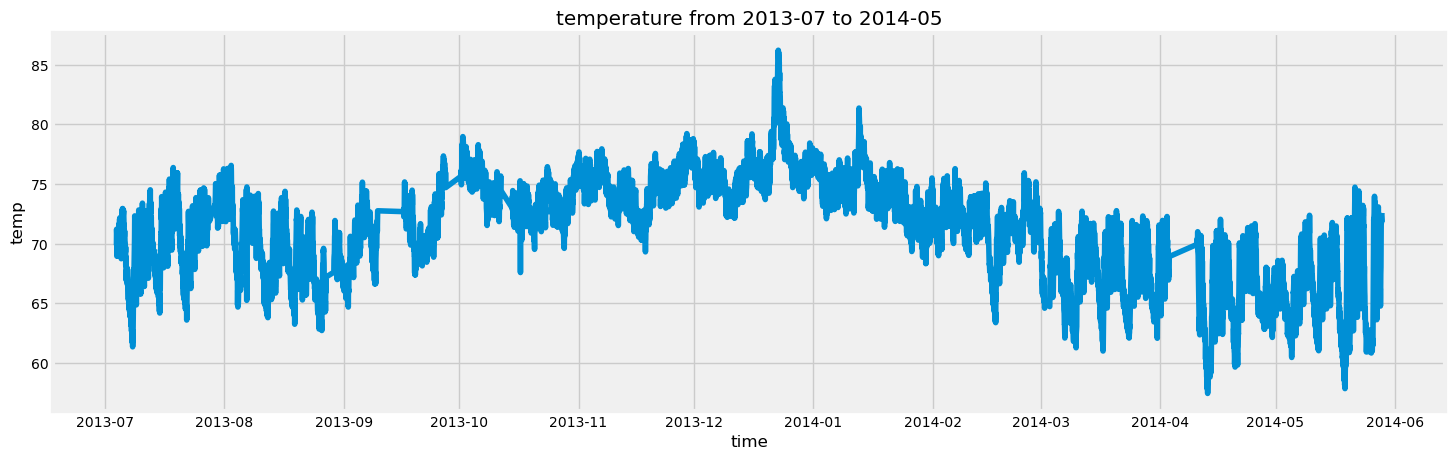

In [72]:
# Plot the temperature
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df['timestamp'],df['value']) 
plt.gca().set(xlabel ='time', ylabel='temp',title ='temperature from 2013-07 to 2014-05');

#### Observations ####
From the plot above, I noticed the gaps in the data. For example,the flat line between 2013-09 to 2013-10. We need to explore more about the missing timestamps and fill the gaps.

In [73]:
df.timestamp.diff().value_counts()

0 days 01:00:00    7256
4 days 00:00:00       1
7 days 06:00:00       1
0 days 15:00:00       1
1 days 08:00:00       1
2 days 23:00:00       1
1 days 06:00:00       1
2 days 00:00:00       1
6 days 16:00:00       1
0 days 03:00:00       1
0 days 02:00:00       1
Name: timestamp, dtype: int64

In [74]:
# Find the missing dates 
df_timestamp_idx = df.set_index(df.timestamp)
ref_date_range = pd.date_range('2013-07-04 00:00:00','2014-05-28 15:00:00', freq='60Min')

ref_df = pd.DataFrame(np.random.randint(1, 20, (ref_date_range.shape[0], 1)))
ref_df.index = ref_date_range

# check for missing datetime index values based on reference index
missing_dates = ref_df.index[~ref_df.index.isin(df_timestamp_idx.index)]
print(missing_dates)
print(len(missing_dates))

DatetimeIndex(['2013-07-28 02:00:00', '2013-07-28 05:00:00',
               '2013-07-28 06:00:00', '2013-07-28 07:00:00',
               '2013-07-28 08:00:00', '2013-07-28 09:00:00',
               '2013-07-28 10:00:00', '2013-07-28 11:00:00',
               '2013-07-28 12:00:00', '2013-07-28 13:00:00',
               ...
               '2014-04-10 05:00:00', '2014-04-10 06:00:00',
               '2014-04-10 07:00:00', '2014-04-10 08:00:00',
               '2014-04-10 09:00:00', '2014-04-10 10:00:00',
               '2014-04-10 11:00:00', '2014-04-10 12:00:00',
               '2014-04-10 13:00:00', '2014-04-10 14:00:00'],
              dtype='datetime64[ns]', length=621, freq=None)
621


In [75]:
# Miss 621 timestamps
# Add the missingg dates and time to the dataframe 
df_ts = df.set_index(['timestamp']).reindex(ref_date_range,fill_value = np.nan) #reset_index().rename(columns={'index':'timestamp'})
# Data frame with timstamp as index
df_ts.head()

,value
2013-07-04 00:00:00,69.880835
2013-07-04 01:00:00,71.220227
2013-07-04 02:00:00,70.877805
2013-07-04 03:00:00,68.959400
2013-07-04 04:00:00,69.283551


In [13]:
# Validate the number of added timestamps
df_ts.isna().sum()

value    621
dtype: int64

#### Missing value imputation ####

Our data is univariate time series, which temperature is the only varying variable

Possible methods
* Use the rolling average
* Use interpolation:
    * linear interpolation
    * spine interpolation

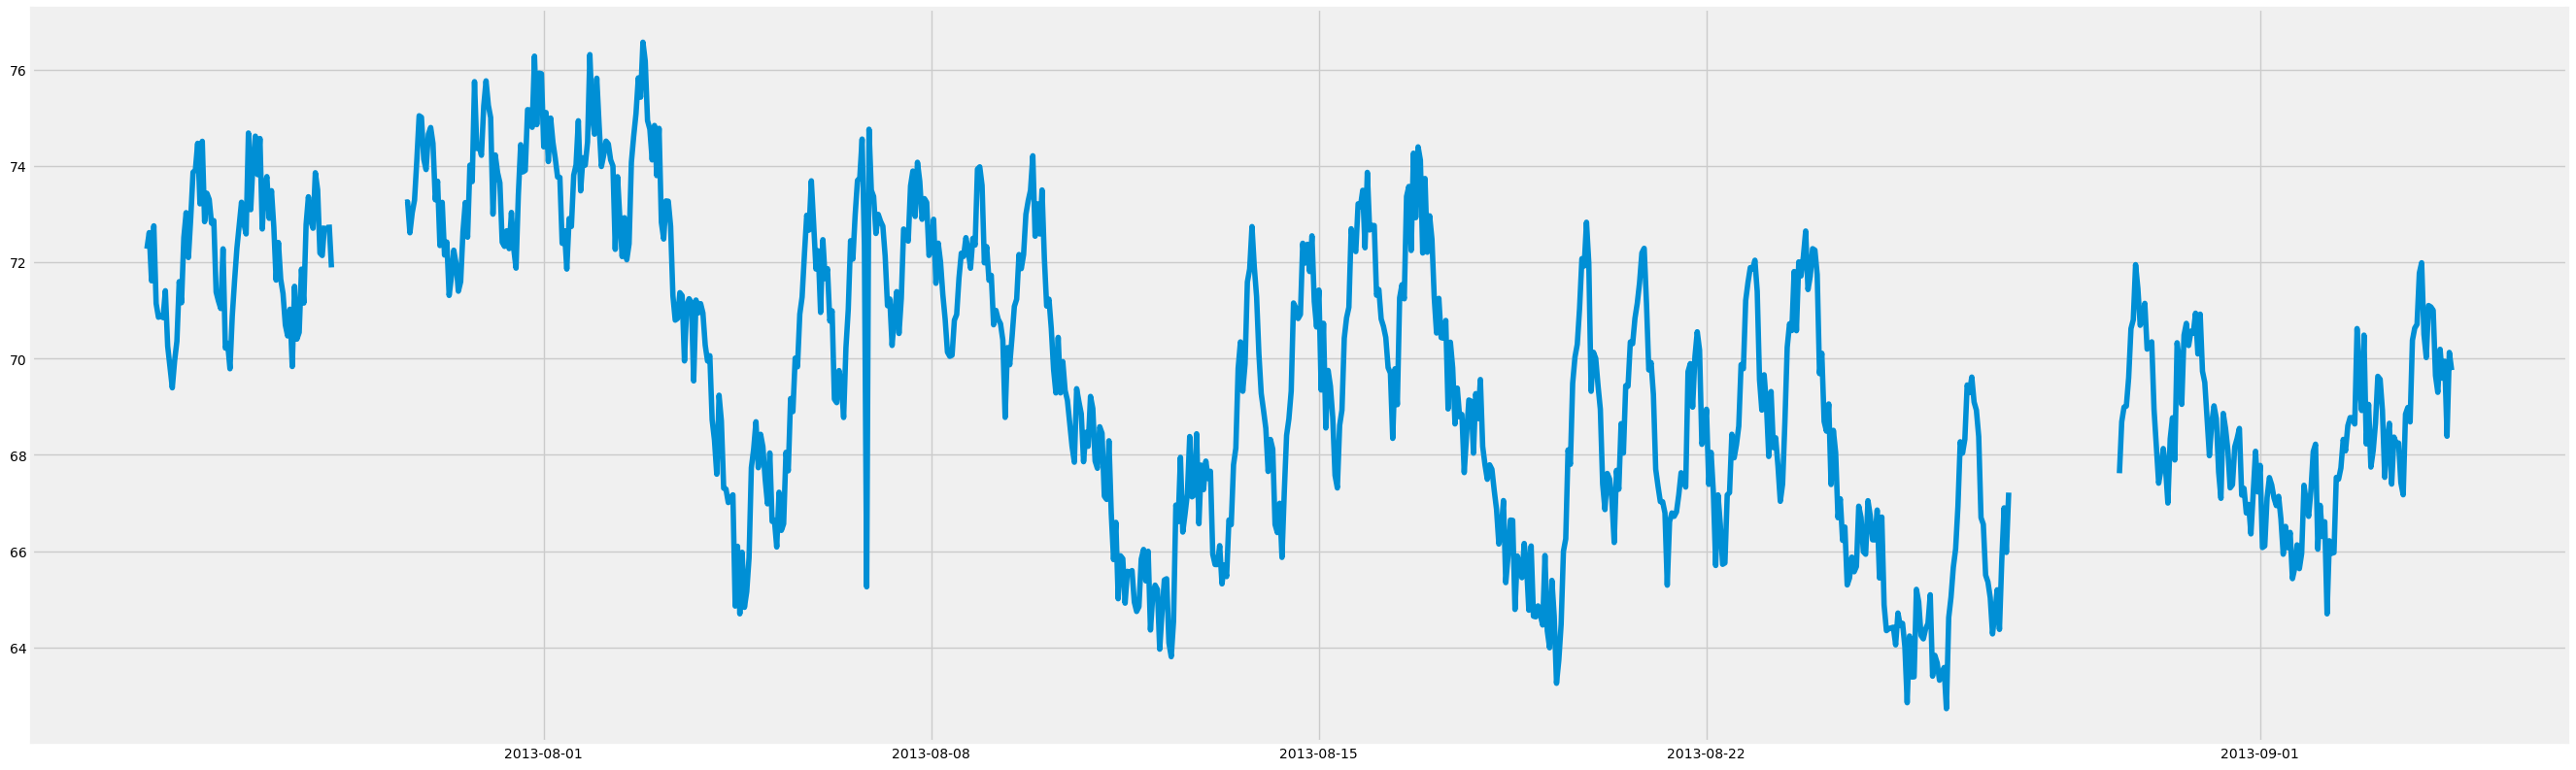

In [85]:
# Visulize missing points 
plt.figure(figsize=(30,10), dpi=100)
# Check data points from 500 to 1500
# Plost partial data for visualization purpose
plt.plot(df_ts['value'][500:1500]); 

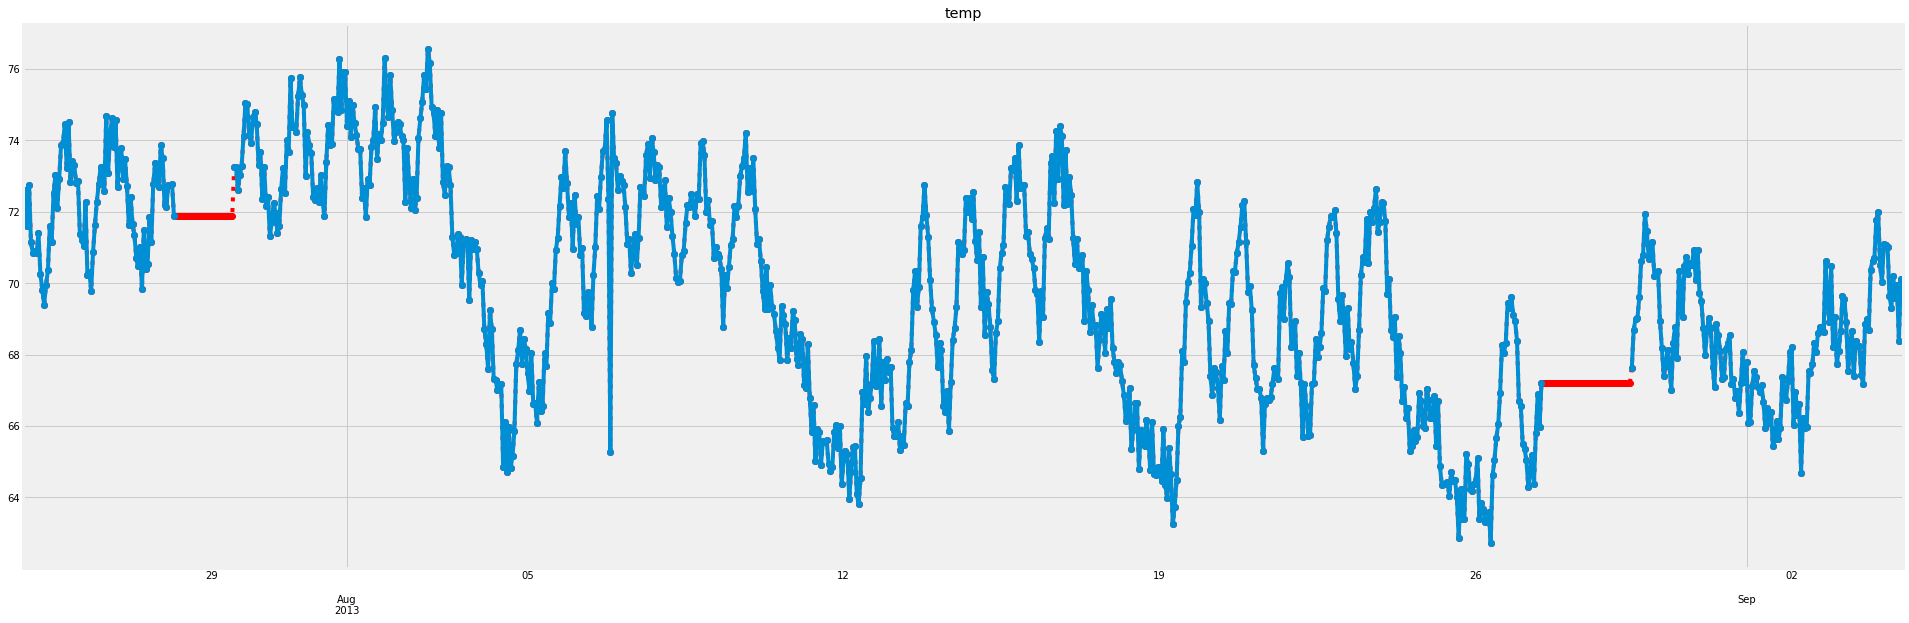

In [86]:
fillna_imput=df_ts.copy(deep=True)
fillna_imput.fillna(method='pad', inplace=True)
fillna_imput['value'][500:1500].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))
df_ts['value'][500:1500].plot(title='temp', marker='o', figsize=(30,10));

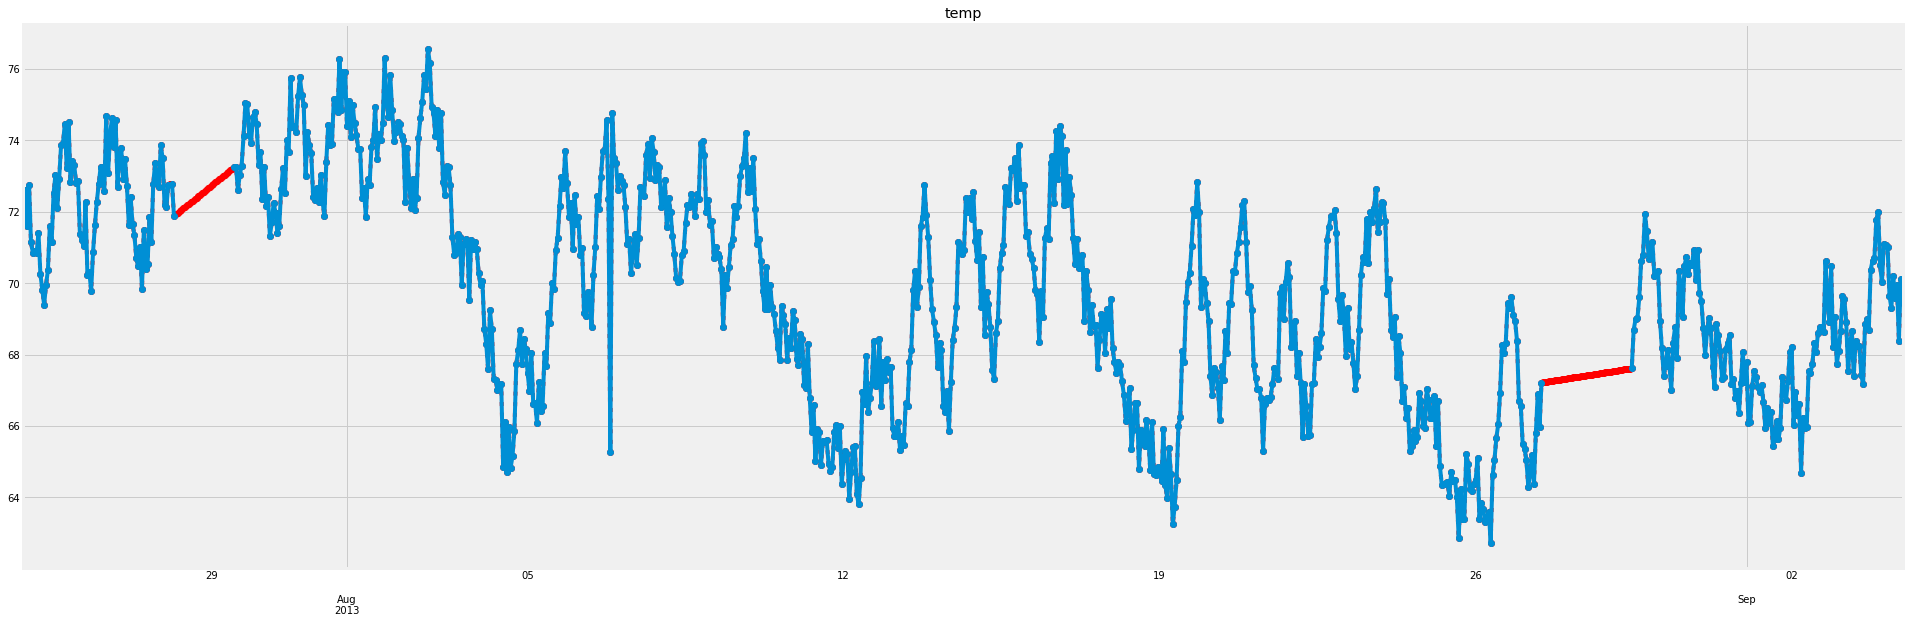

In [87]:
time_input=df_ts.copy(deep=True)
time_input.interpolate(method='time', inplace=True)
time_input['value'][500:1500].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))
df_ts['value'][500:1500].plot(title='temp', marker='o', figsize=(30,10));

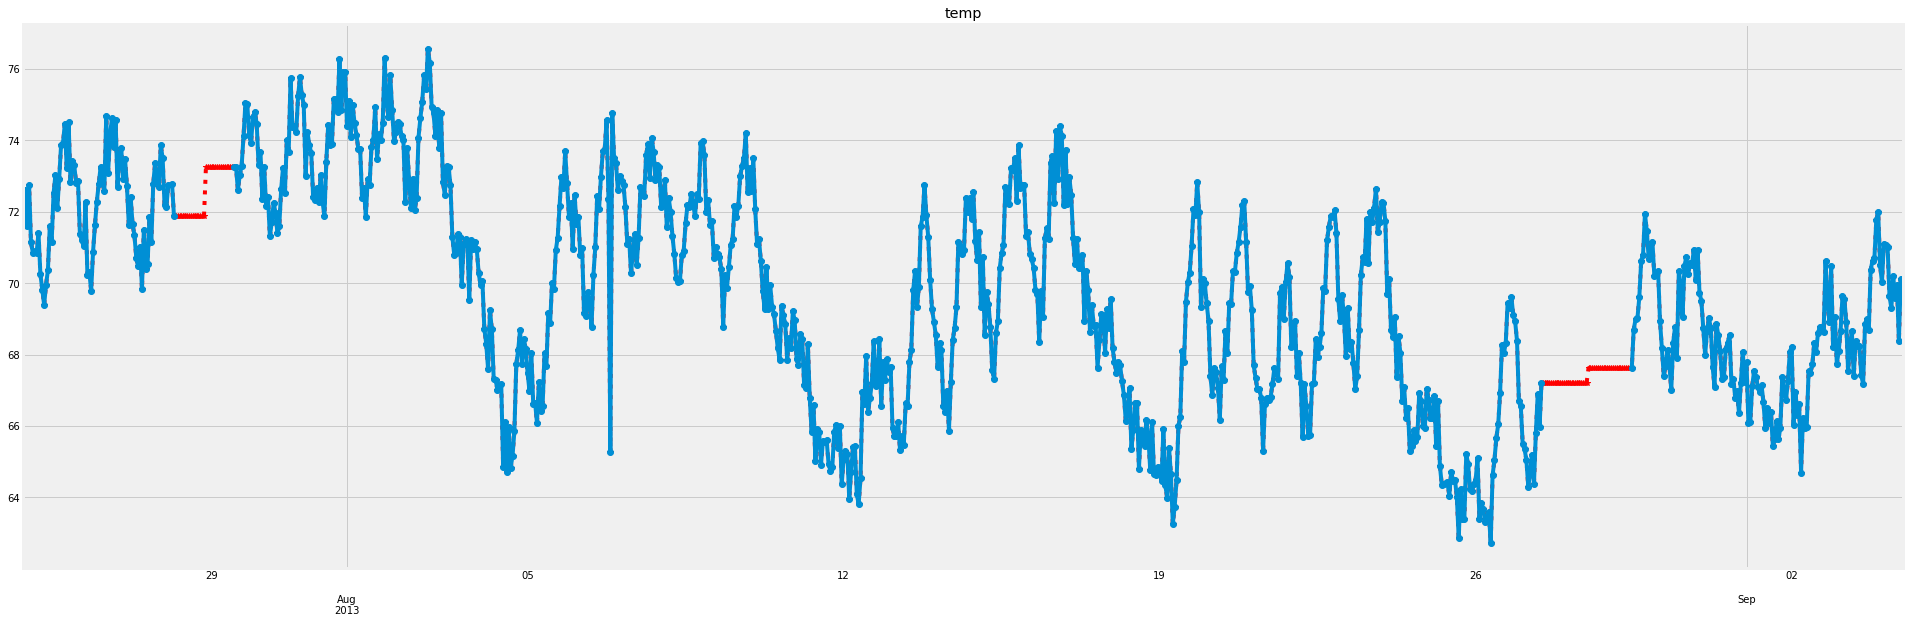

In [88]:
nearest_input=df_ts.copy(deep=True)
nearest_input.interpolate(method='nearest', inplace=True)

nearest_input['value'][500:1500].plot(color='red', marker='*', linestyle='dotted', figsize=(30, 5))
df_ts['value'][500:1500].plot(title='temp', marker='o', figsize=(30, 10));

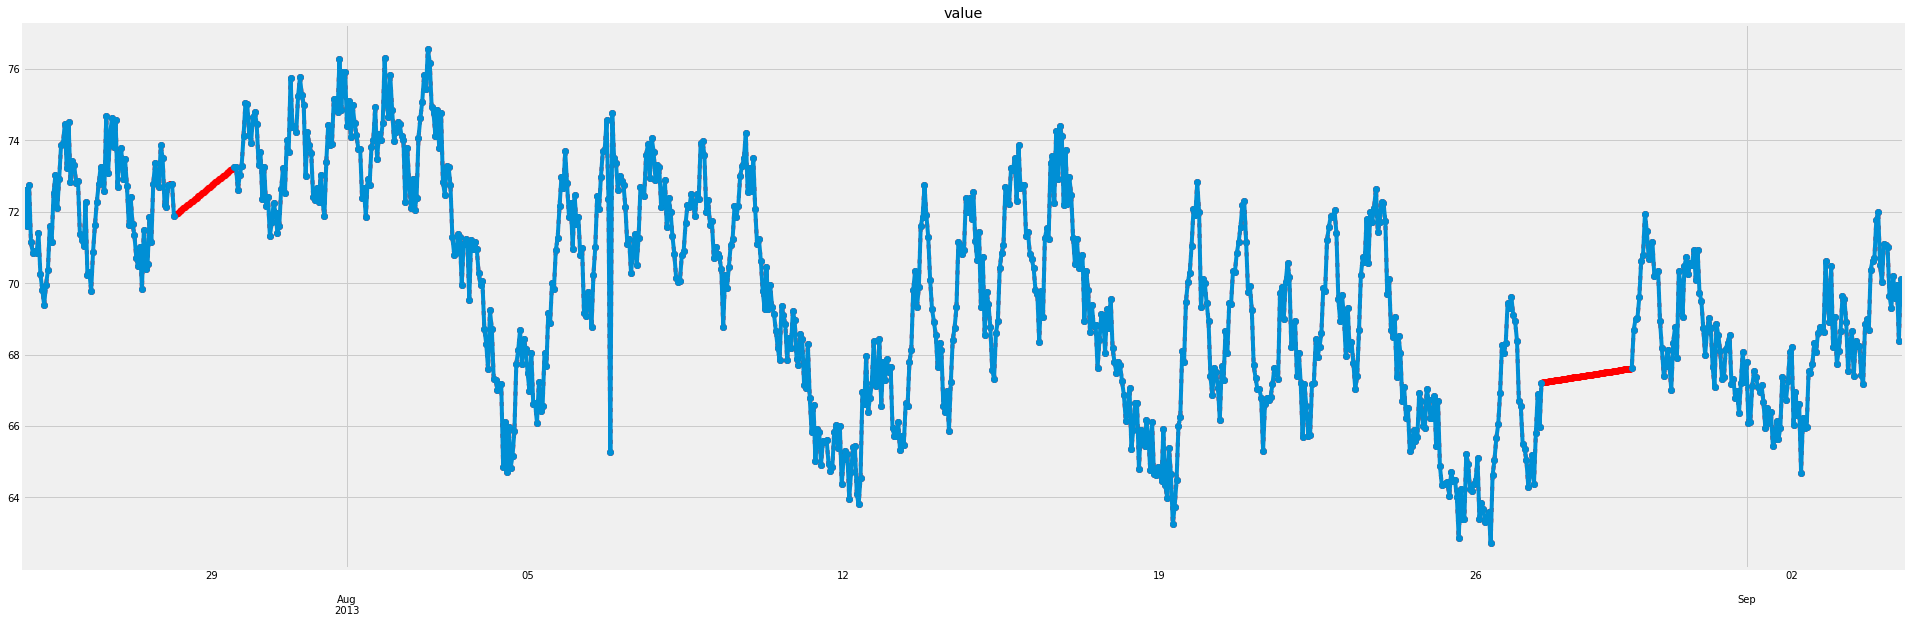

In [89]:
linear_imput=df_ts.copy(deep=True)
linear_imput.interpolate(method='linear', inplace=True)

linear_imput['value'][500:1500].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))
df_ts['value'][500:1500].plot(title='value', marker='o', figsize=(30, 10));

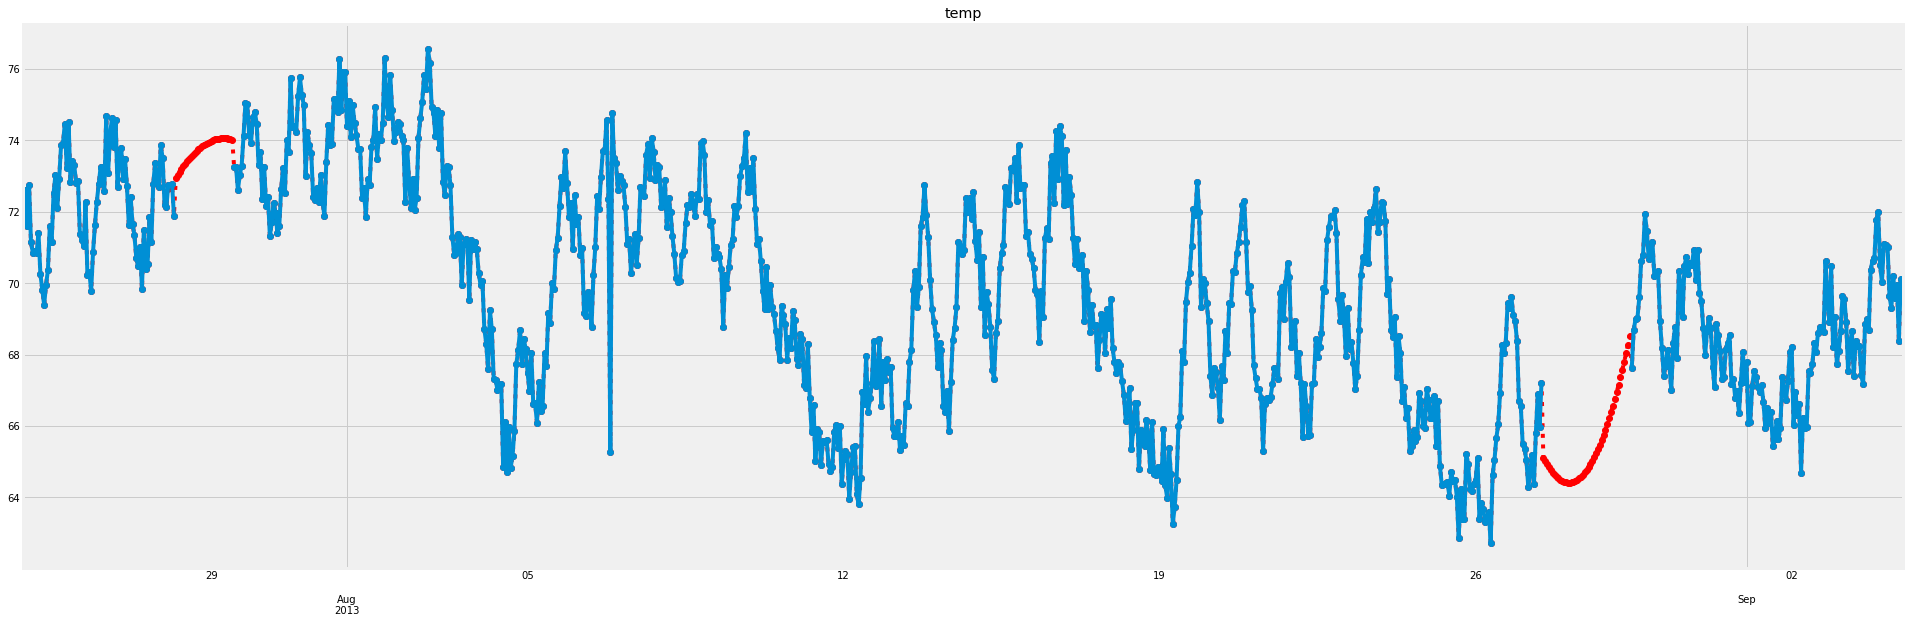

In [90]:
spline_input=df_ts.copy(deep=True)
spline_input.interpolate(method='spline', order =2, inplace=True)

spline_input['value'][500:1500].plot(color='red', marker='o', linestyle='dotted', figsize=(30, 5))
df_ts['value'][500:1500].plot(title='temp', marker='o', figsize=(30, 10));

#### Observations ####

* From the plots of missing values impuatation above, I don't think any of the methods did a good job to catch the trend of data and fill the missing values. Due to time constraint, I am not going to fill the missing dates with estimated values. Instead, I ma going to focus on model development based on the orginal data.


<a id = "data"></a>
#### 3. Feature Engineering ####

##### Question 2 - Feature Engineering
* Extract some features from timstamp such as hours, weekdays, etc...
* Aggregate values by hourly, weekly, monthly and plot the values 
* Save adjusted features for modeling 

In [91]:
# Extract some features from timestamp 
df_origin['month'] = df_origin.timestamp.apply(lambda x: x.month)
df_origin['day_of_week'] = df_origin.timestamp.dt.day_name()
df_origin['day_in_week'] = df_origin['timestamp'].dt.dayofweek
df_origin['weekday'] = (df_origin['timestamp'].dt.dayofweek < 5).astype(int)
df_origin['hours'] = df_origin.timestamp.dt.hour
df_origin['daylight'] = ((df_origin['hours'] >= 7) & (df_origin['hours'] <= 22)).astype(int)
df_origin.head()

,timestamp,value,month,day_of_week,day_in_week,weekday,hours,daylight
0,2013-07-04 00:00:00,69.880835,7,Thursday,3,1,0,0
1,2013-07-04 01:00:00,71.220227,7,Thursday,3,1,1,0
2,2013-07-04 02:00:00,70.877805,7,Thursday,3,1,2,0
3,2013-07-04 03:00:00,68.959400,7,Thursday,3,1,3,0
4,2013-07-04 04:00:00,69.283551,7,Thursday,3,1,4,0


In [111]:
def plotBoxByTime(data,bytime):
    plt.figure(figsize=(16,5), dpi=100)
    sns.boxplot(x= bytime,y ='value', data = data)
    plt.grid(True)

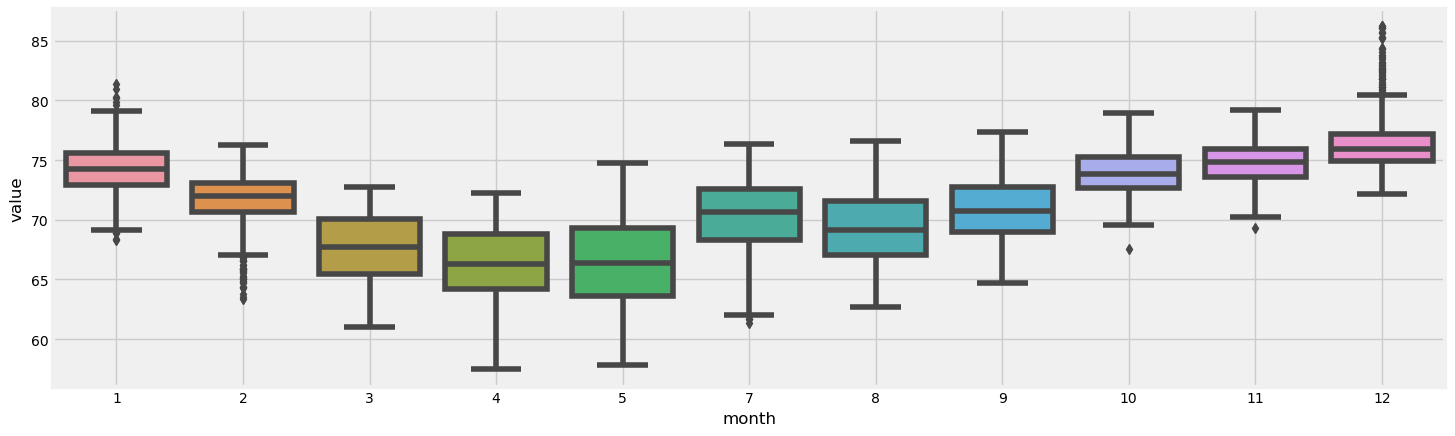

In [112]:
# Box plot by month 
plotBoxByTime(df_origin,'month')

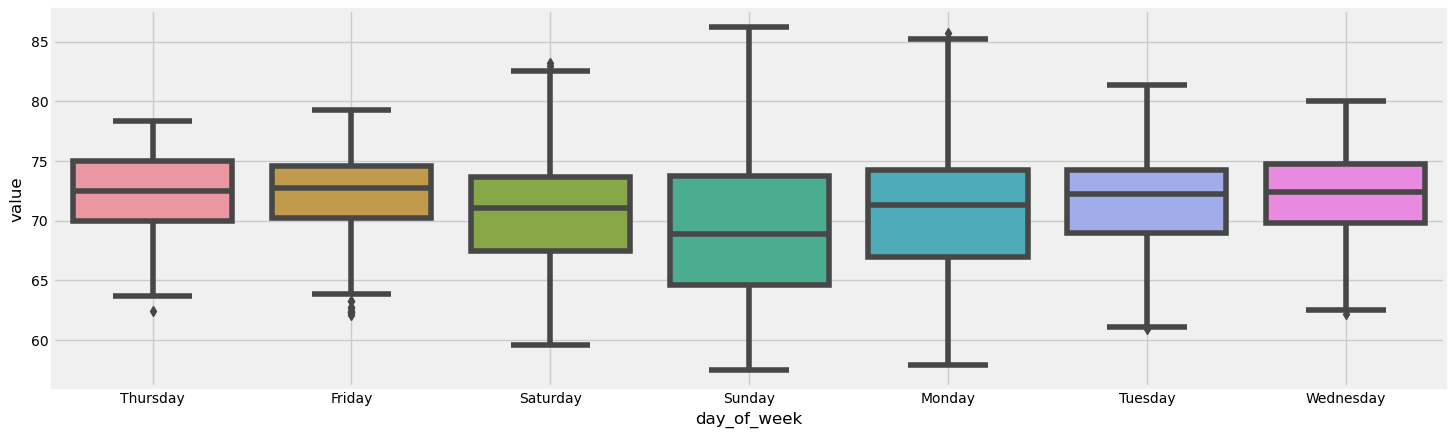

In [114]:
# Box plot by day of week
plotBoxByTime(df_origin,'day_of_week')

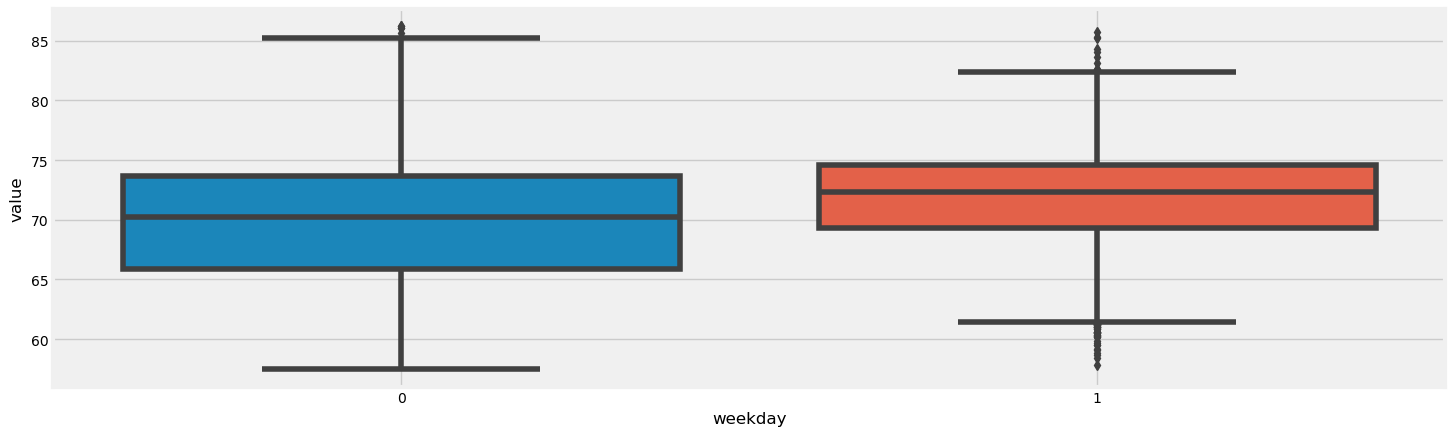

In [115]:
# Box plot by week of day
plotBoxByTime(df_origin,'weekday')

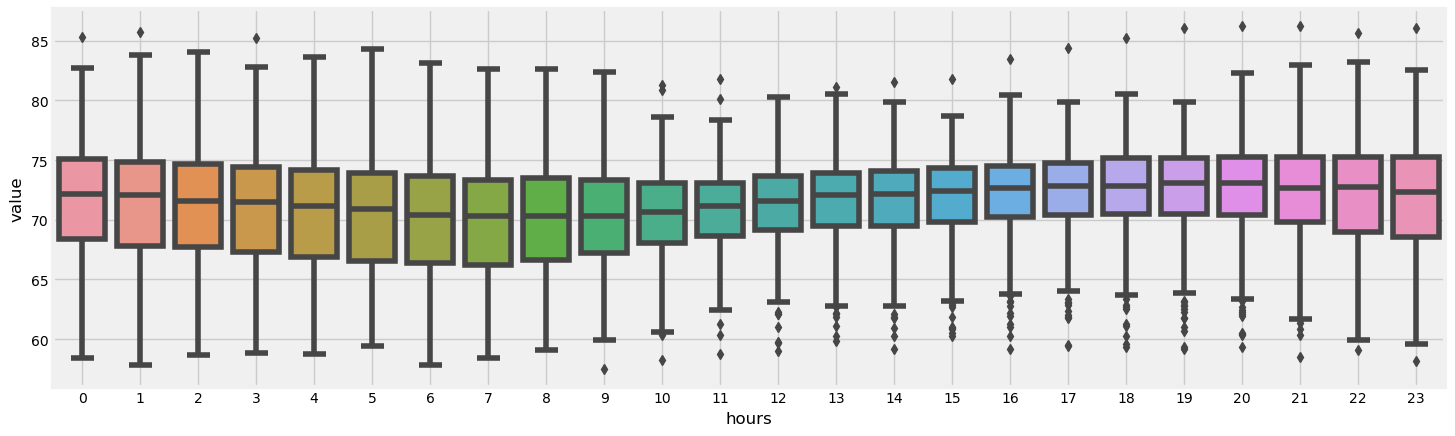

In [117]:
# Box plot by hours
plotBoxByTime(df_origin,'hours')

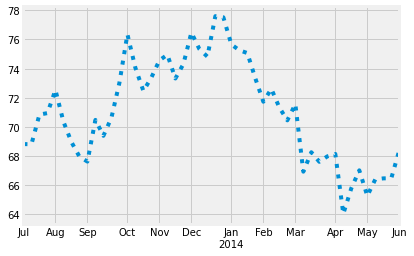

In [26]:
# Check average weekly temp
weekly = df_ts.value.resample('W').mean()
weekly.plot(style =[':','--','-']);

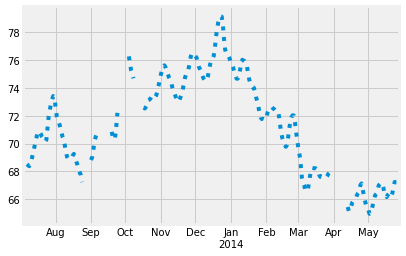

In [27]:
# Check averavge daily temp with rolling window = 5
daily = df_ts.value.resample('D').mean()
daily.rolling(7, center = True).mean().plot(style =[':','--','-']);

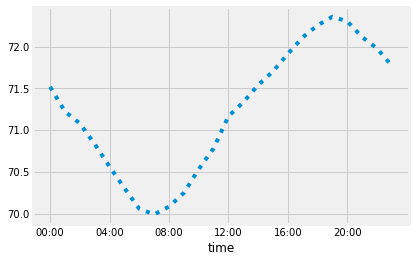

In [28]:
# Check hourly average temp
by_time = df_ts.groupby(df_ts.index.time).mean()
hourly_ticks = 4*60*60*np.arange(6)
by_time.value.plot(xticks =hourly_ticks,style =[':','--','-']);

#### Observation ####
* I plotted the average temperature by hours, days, weekly and monthly. 
    * The patterns align with our assumptions. For example, the average temperature in weekdays is higher than the average temperature in the weekends. The average temperature during the winter times is higher than the sumer times.

<a id = "md"></a>
#### 4. Model Devlopment ####


#### Question 3 - Anomaly Detection - Statistical Model  ####

Possible statiscal models that can be used for anomaly detection: 
* Moving average
* Exponential smothing 
* SARIMA

For simplicity, chose moving average as an approach in this case

In [128]:
# Set timestamp as index
df_stats = df.set_index('timestamp')

In [129]:
# Calculate average of the last n obersations 
def moving_average(series, n):
    return np.average(series[-n:])
# last 24 hours prediction
moving_average(df_stats, 24) 

69.51417388625

In [137]:
# Plost average, confidence interval and anomalies based on the rollling window
# Specify scale =2.576 for 99% confidence interval
def plotMovingAverage(series, window, plot_intervals=False, scale=2.576, plot_anomalies=False):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(30,15))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

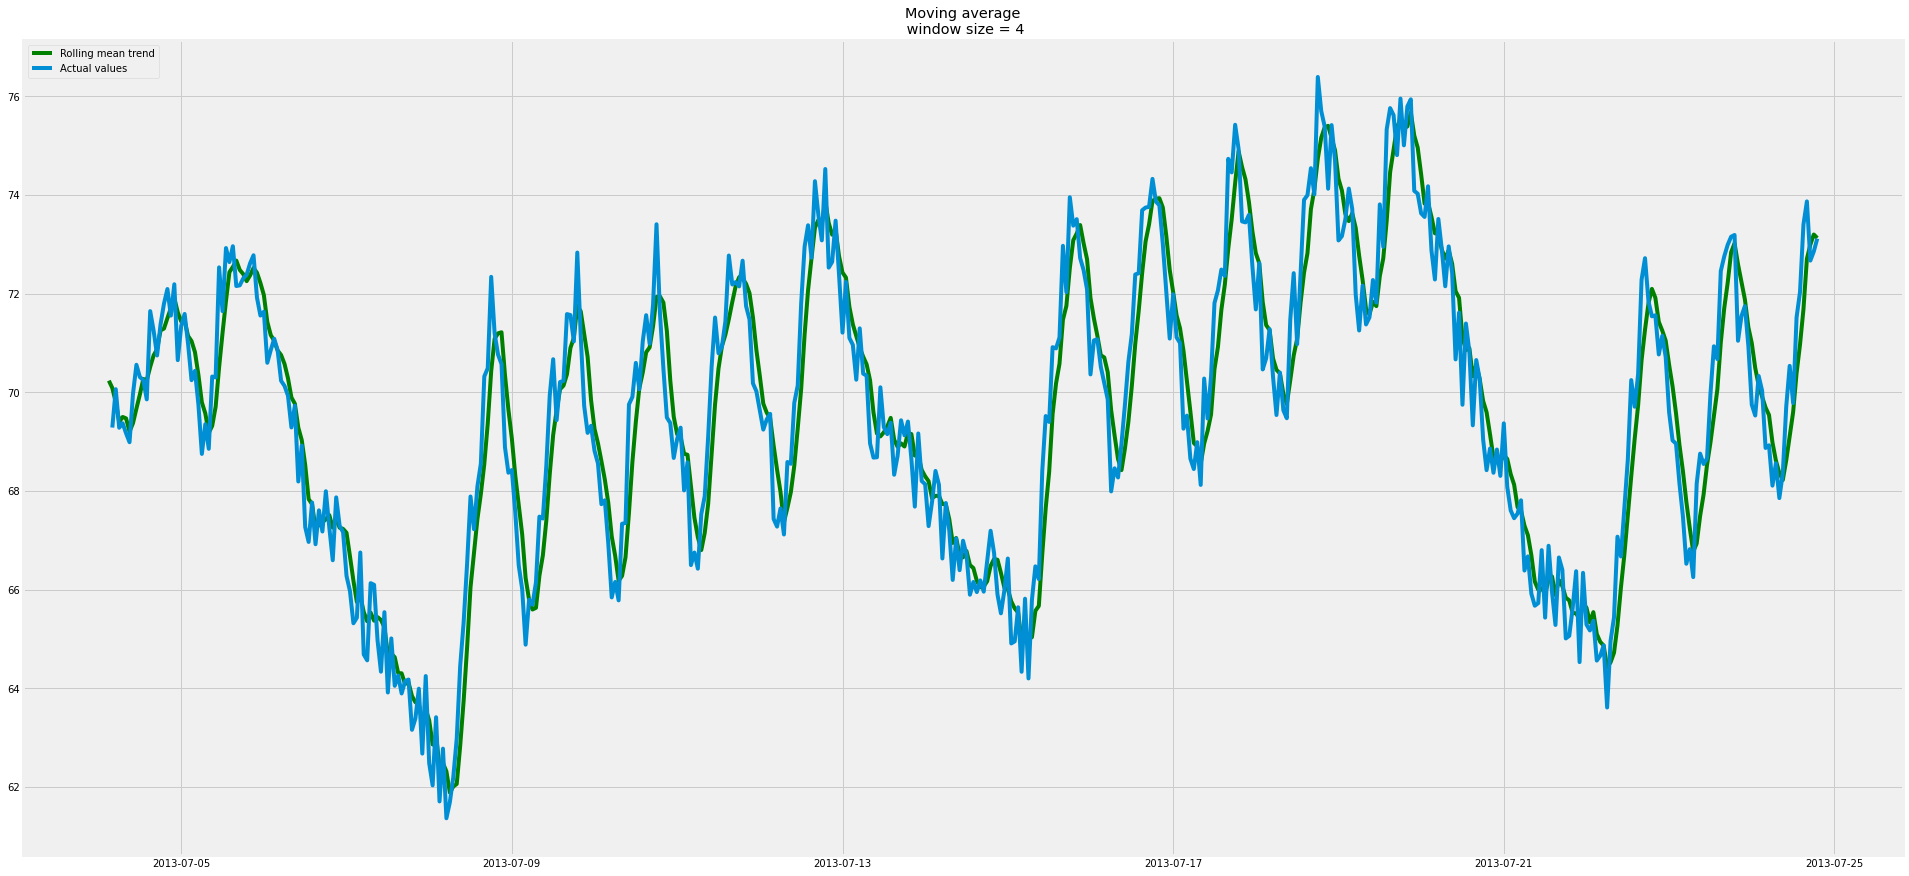

In [132]:
plotMovingAverage(df_stats[:500], 4) 

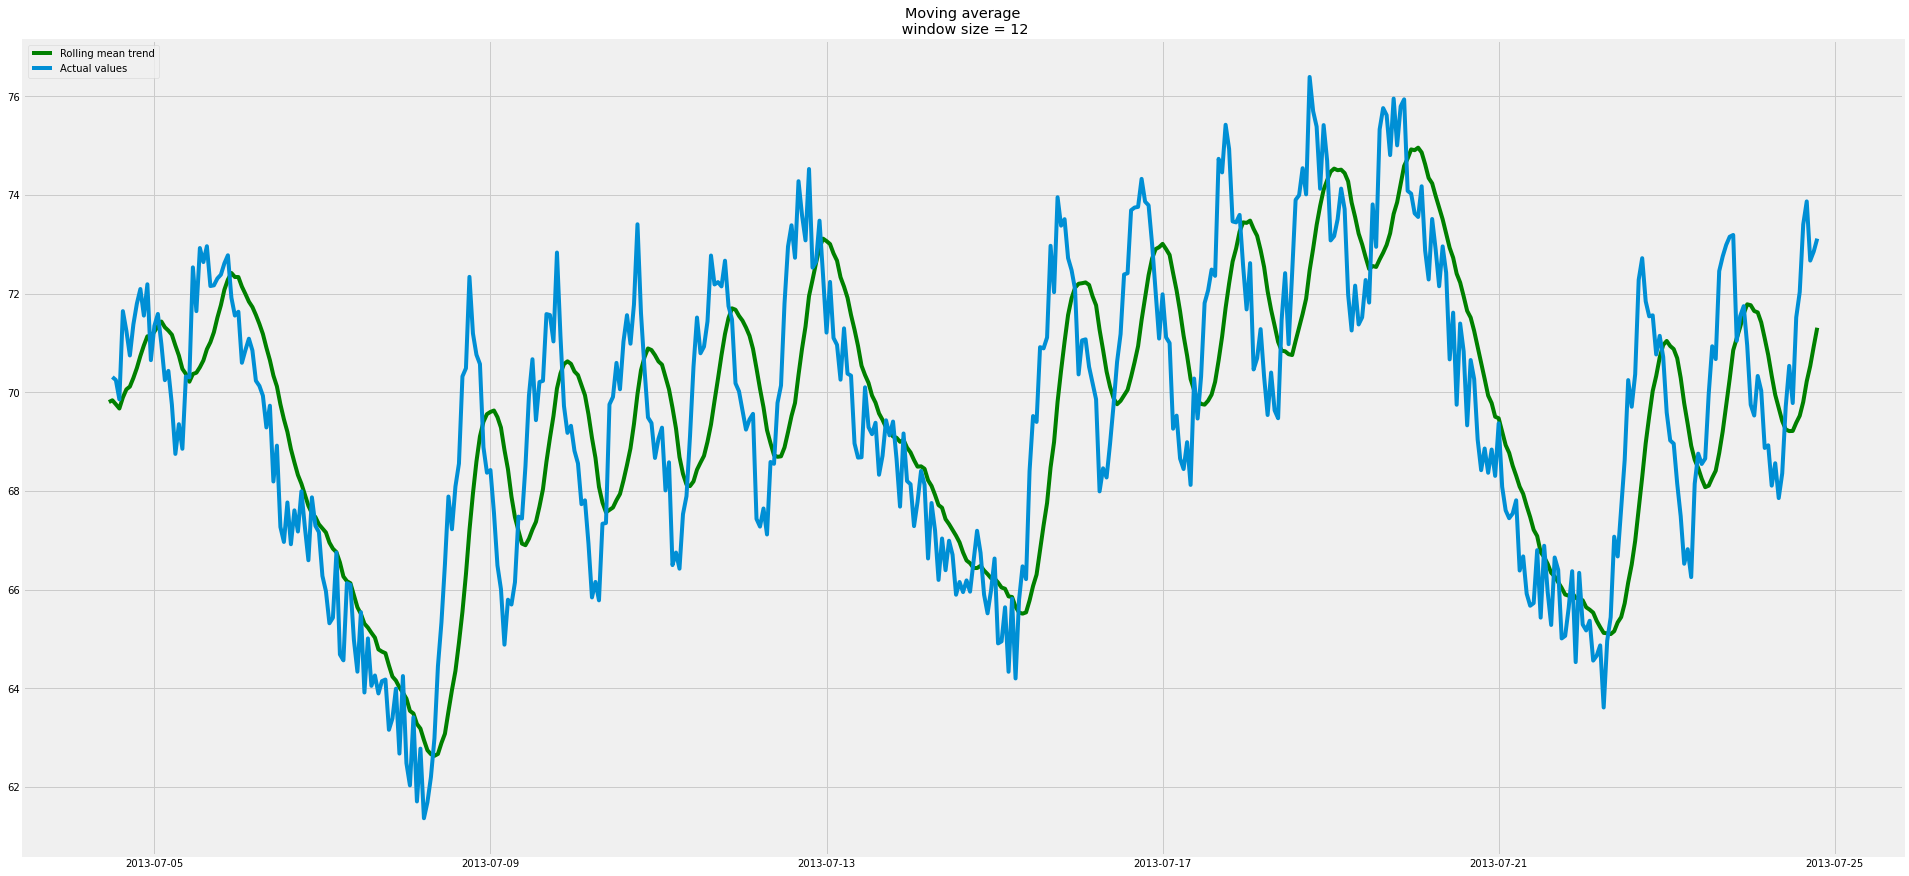

In [133]:
plotMovingAverage(df_stats[:500], 12) 

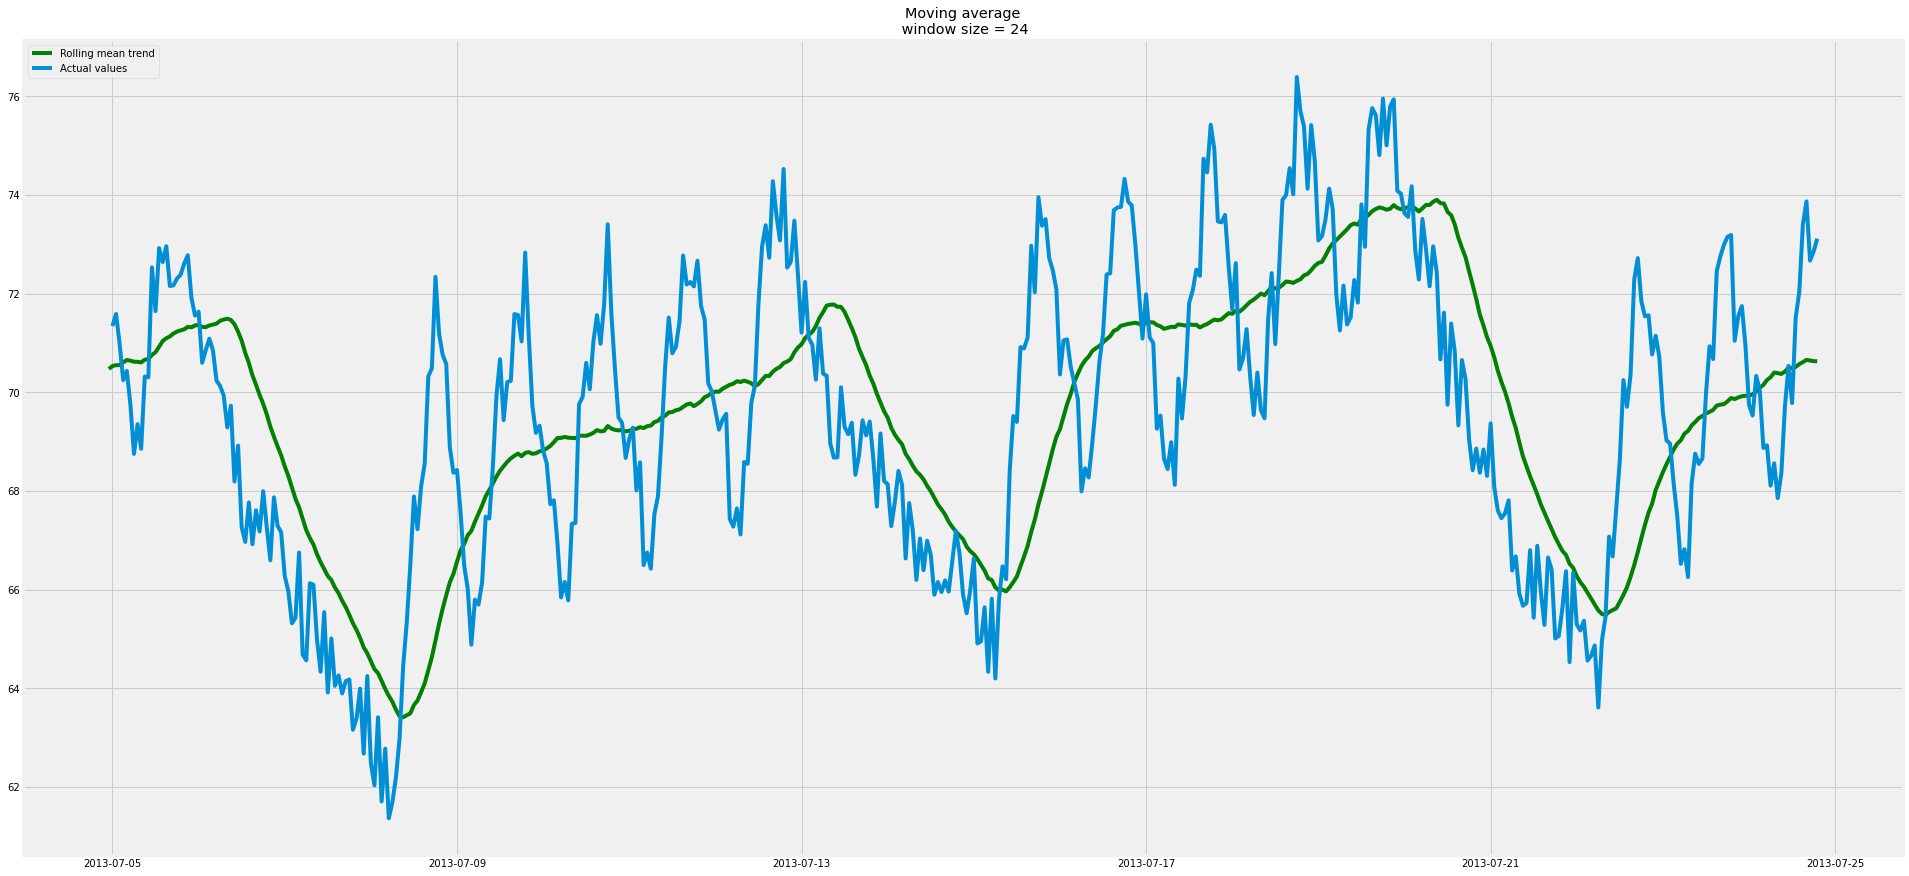

In [134]:
plotMovingAverage(df_stats[:500], 24)

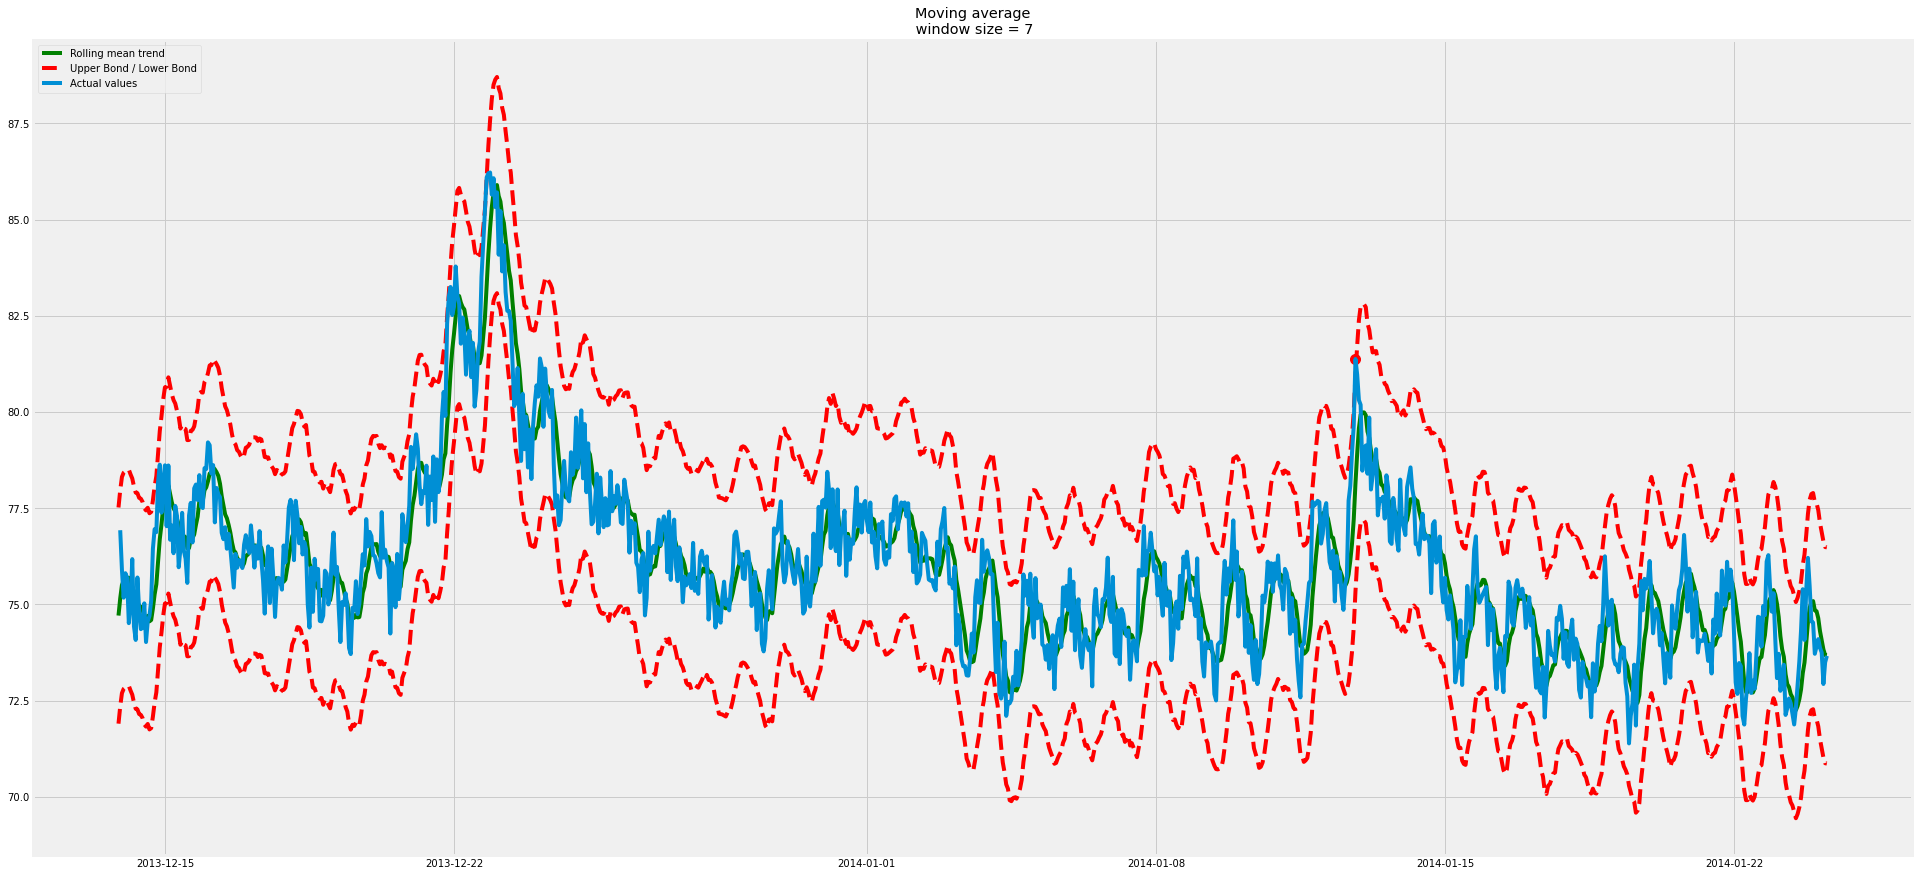

In [140]:
plotMovingAverage(df_stats[3500:4500],7,plot_intervals = True, plot_anomalies = True)

 #### Observation ####
 * For visualization purpose, only chosse part of the data to show
 * All data points are in the confidence interval and no anomaly is detected

 #### Question 4 -  Anomaly Detection using Clustering ####
 * I chose KMeans for clustering based on the following reasons:
     1. Relatively simple to implement
     2. Guarantees convergence
     3. Easy to explain and interpret


In [141]:
# Select features for KMeans
# Standardize feautures to the same scale 
data_cluster = df_origin[['value','month','hours']]
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_cluster)
data_cluster_scaled = pd.DataFrame(np_scaled)

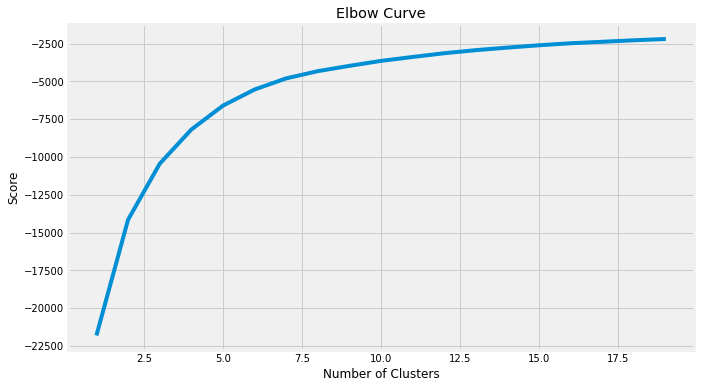

In [142]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data_cluster_scaled) for i in n_cluster]
scores = [kmeans[i].score(data_cluster_scaled) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

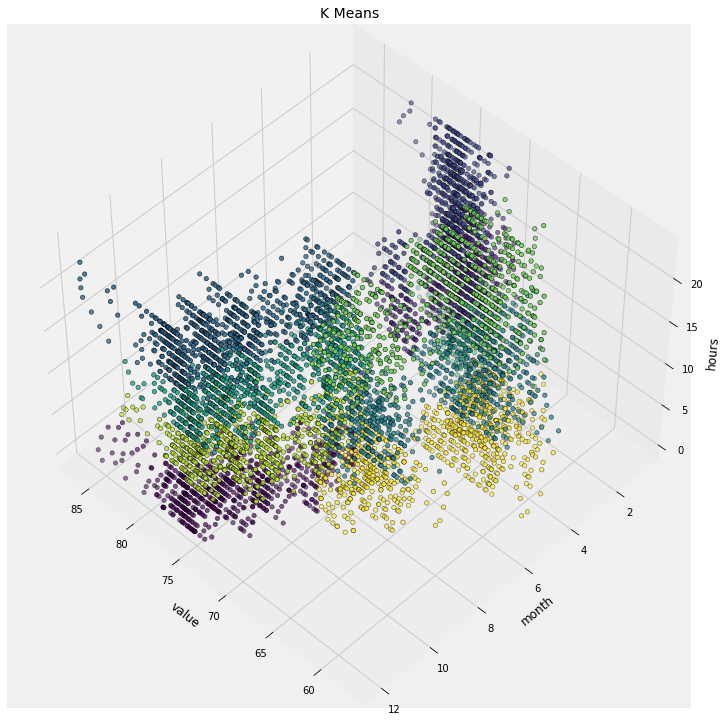

In [143]:
X = df_origin[['value','month','hours']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_

#Plotting
fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel('value')
ax.set_ylabel('month')
ax.set_zlabel('hours')
plt.title("K Means", fontsize=14);

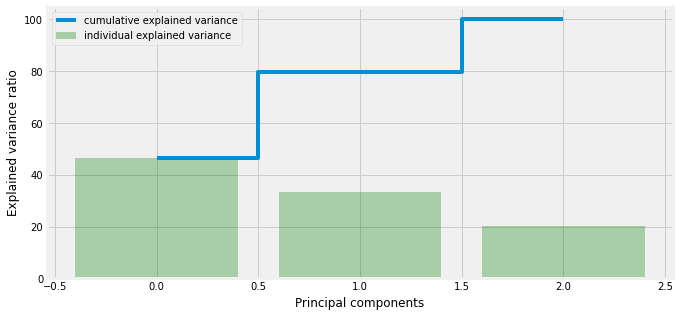

In [144]:
data = df_origin[['value','month','hours']]
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [145]:
df_origin.head()

,timestamp,value,month,day_of_week,day_in_week,weekday,hours,daylight
0,2013-07-04 00:00:00,69.880835,7,Thursday,3,1,0,0
1,2013-07-04 01:00:00,71.220227,7,Thursday,3,1,1,0
2,2013-07-04 02:00:00,70.877805,7,Thursday,3,1,2,0
3,2013-07-04 03:00:00,68.959400,7,Thursday,3,1,3,0
4,2013-07-04 04:00:00,69.283551,7,Thursday,3,1,4,0


In [146]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cluster_scaled)
# standardize these 2 new features
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_pca)
data_cluster_scaled = pd.DataFrame(np_scaled)

In [147]:
df_origin['principal_feature1'] = data_cluster_scaled[0]
df_origin['principal_feature2'] = data_cluster_scaled[1]

In [148]:
# Specify outliers fraction 
outliers_fraction = 0.01

In [149]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df_origin['anomaly1'] = (distance >= threshold).astype(int)

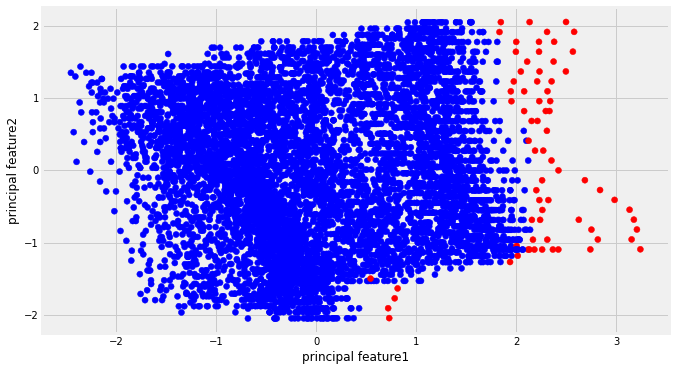

In [150]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df_origin['principal_feature1'], df_origin['principal_feature2'], c=df_origin["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [151]:
df_origin.head()

,timestamp,value,month,day_of_week,day_in_week,weekday,hours,daylight,principal_feature1,principal_feature2,anomaly1
0,2013-07-04 00:00:00,69.880835,7,Thursday,3,1,0,0,-0.440796,1.614104,0
1,2013-07-04 01:00:00,71.220227,7,Thursday,3,1,1,0,-0.224417,1.477922,0
2,2013-07-04 02:00:00,70.877805,7,Thursday,3,1,2,0,-0.244859,1.340910,0
3,2013-07-04 03:00:00,68.959400,7,Thursday,3,1,3,0,-0.487218,1.203122,0
4,2013-07-04 04:00:00,69.283551,7,Thursday,3,1,4,0,-0.413797,1.066440,0


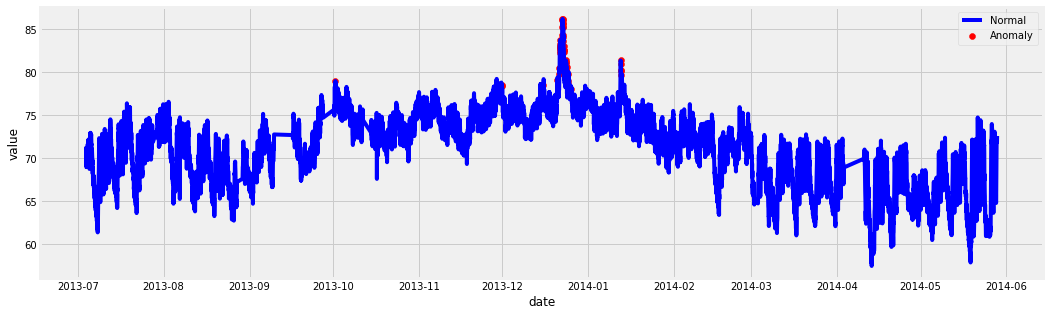

In [160]:
fig, ax = plt.subplots(figsize=(16,5))
a = df_origin.loc[df_origin['anomaly1']== 1, ['timestamp', 'value']] #anomaly

ax.plot(df_origin['timestamp'], df_origin['value'], color='blue', label='Normal')
ax.scatter(a['timestamp'],a['value'], color='red', label='Anomaly')
plt.xlabel('date')
plt.ylabel('value')
plt.legend()
plt.show();

 #### Question 4 -  Anomaly Detection using classification ####
 * I chose islocation forest for classification based on the following reasons:
     1. Relatively simple to implement
     2. Robust and easy to optimize 
     3. Easy to explain and interpret

In [161]:
# Take useful feature and standardize them 
data_if = df_origin[['value', 'hours', 'daylight', 'day_in_week', 'weekday']]
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_if)
data_if = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction) #outlier fraction is defined before, which is 0.01
model.fit(data_if)
# add the data to the main  
df_origin['anomaly2'] = pd.Series(model.predict(data_if))
df_origin['anomaly2'] = df_origin['anomaly2'].map( {1: 0, -1: 1} )
print(df_origin['anomaly2'].value_counts())

0    7195
1      72
Name: anomaly2, dtype: int64


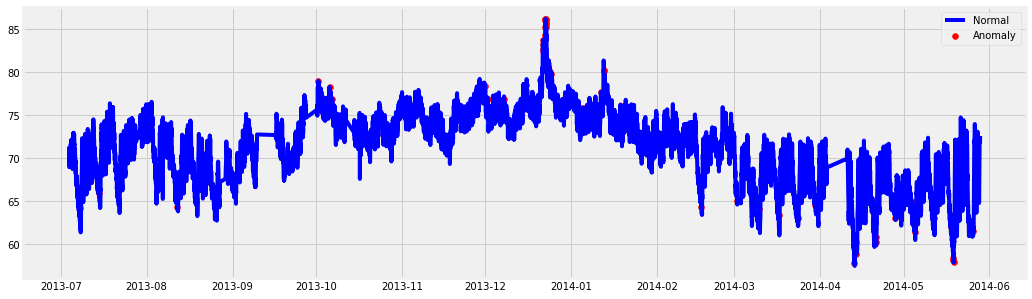

In [162]:
# visualization
fig, ax = plt.subplots(figsize=(16,5))

a = df_origin.loc[df_origin['anomaly2'] == 1, ['timestamp', 'value']] #anomaly
ax.plot(df_origin['timestamp'], df_origin['value'], color='blue', label = 'Normal')
ax.scatter(a['timestamp'],a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

<a id = "con"></a>
#### 5 Conclusions ####
* Model comparison:
    * Kmeans and isolation tree both catch the anomalies on the uppper side; Isolation tree catches the lower side. 
* Next steps: 
    1. Do more research on missing values imputation for time series data.
    2. Explore other techniques for anomaly detection. For example, use Facebook open source prophet for anomaly detection (It is an easy tool to implement), try ARIMA model, ...etc.
    3. Clean up and modualarize the codes. For example, change the plots to be interactive. 
    
    
#### Question 6:  How will you present your findings? #### 
* Depends on audience.
    1. For co-coworkers: push the notebook to Github and walk through my findings.
    2. For management: prepare a PPT deck with summary and next steps.